# 1. Notation and Data

The first step is to activate the packages and load the data.

In [1]:
import pyreadr 
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from datetime import datetime as dt
                                                                  
data_ml = pyreadr.read_r(# insert path of data_ml.RData )
data_ml = data_ml["data_ml"]    

In [2]:
data_ml.date = pd.to_datetime(data_ml.date)

data_ml = data_ml.loc[(data_ml['date'] > "1999-12-31") & (data_ml['date'] < "2019-01-01")]
data_ml.sort_values(by = ['stock_id','date'], inplace = True)
data_ml.iloc[0:6,:6]

,stock_id,date,Advt_12M_Usd,Advt_3M_Usd,Advt_6M_Usd,Asset_Turnover
177278,1,2000-01-31,0.41,0.39,0.42,0.19
177279,1,2000-02-29,0.41,0.39,0.40,0.19
182907,1,2000-03-31,0.40,0.37,0.37,0.20
182908,1,2000-04-30,0.39,0.36,0.37,0.20
182909,1,2000-05-31,0.40,0.42,0.40,0.20
182910,1,2000-06-30,0.41,0.47,0.42,0.21


Then, a first graph to check data availability through time.

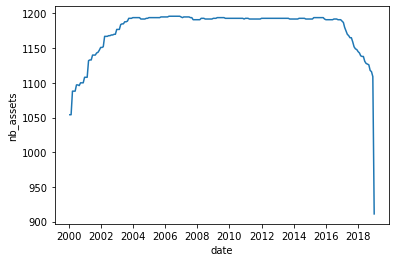

In [3]:
plt.plot(data_ml.date.unique(), data_ml.groupby('date').stock_id.count())
plt.xlabel("date")
plt.ylabel("nb_assets")
plt.show()

There are four immediate **labels** in the dataset: R1M_Usd, R3M_Usd, R6M_Usd and R12M_Usd, which correspond to the 1 month, 3 month, 6 month and 12 month future/forward returns of the stocks. The returns are **total returns**, that is, they incorporate potential **dividend** payments over the considered periods. This is a better proxy of financial gain compared to price returns only. We refer to the analysis of @hartzmark2019dividend for a study on the impact of decoupling price returns and dividends. These labels are located in the last 4 columns of the dataset. We provide their descriptive statistics below.

In [4]:
data_ml.iloc[:,95:].agg(["mean","std", "min","max"]).T 

,mean,std,min,max
R1M_Usd,0.012732,0.176431,-0.922,30.176
R3M_Usd,0.036901,0.328289,-0.929,39.389
R6M_Usd,0.072339,0.527420,-0.980,106.929
R12M_Usd,0.136865,0.737872,-0.991,95.972


In anticipation for future models, we keep the name of the predictors in memory. 
<br>
In addition, we also keep a much shorter list of predictors. 

In [5]:
features = data_ml.columns[2:95]
features_short = ["Div_Yld", "Eps", "Mkt_Cap_12M_Usd", "Mom_11M_Usd", 
                    "Ocf", "Pb", "Vol1Y_Usd"]

The predictors have been uniformized, that is: for any given feature and time point, the distribution is uniform.
<br>
Given 1,207 stocks, the graph below cannot display a perfect rectangle.

<AxesSubplot:>

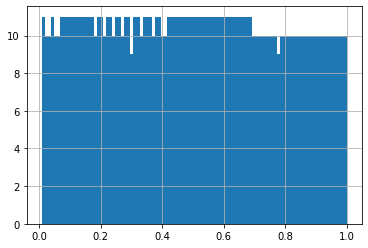

In [6]:
data_ml[data_ml.date == '2000-02-29'].Div_Yld.hist(bins = 100 )

In order to be able to perform classification analyses, we create additional labels that are categorical. 


In [7]:
data_ml['R1M_Usd_C'] = data_ml.R1M_Usd >  data_ml.groupby('date').R1M_Usd.transform('median')
data_ml['R12M_Usd_C'] = data_ml.R12M_Usd >  data_ml.groupby('date').R12M_Usd.transform('median')

####another way
# def get_categorical(x):
#     x['R1M_Usd_C'] = x['R1M_Usd'] > x['R1M_Usd'].median()
#     x['R1M_Usd_C'] = x['R1M_Usd_C'].astype(int)
#     x['R12M_Usd_C'] = x['R12M_Usd'] > x['R12M_Usd'].median()
#     x['R12M_Usd_C'] = x['R12M_Usd_C'].astype(int)
    
#     return x
# data_ml = data_ml.groupby('date').apply(get_categorical)

The new labels are binary: they are equal to 1 (true) if the original return is above that of the median return over the considered period and to 0 (false) if not. Hence, at each point in time, half of the sample equal to zero and the other half to one: some stocks overperforms and others underperform. 

In machine learning, models are estimated on one portion of data (**training set**) and then tested on another portion of the data (**testing set**) to assess their quality. We split our sample accordingly.


In [8]:
separation_date = dt.strptime("2014-01-15","%Y-%m-%d")
training_sample = data_ml[data_ml.date < separation_date]
testing_sample = data_ml[data_ml.date  >= separation_date]

We also keep in memory a few key variables, like the list of asset identifiers and a rectangular version of returns. For simplicity, in the computation of the latter, we shrink the investment universe to keep only the stocks for which we have the maximum number of points.


In [9]:
stock_ids = data_ml.stock_id.unique()                                                               # A list of all stock_ids                                  
stock_days = data_ml.stock_id.value_counts().sort_index()                                           # Compute the number of data points per stock
stock_ids_short = stock_ids[stock_days.values == max(stock_days.values)]                            # Stocks with full data

returns_short = data_ml[data_ml['stock_id'].isin(stock_ids_short)][['date','stock_id','R1M_Usd']]    
#or data_ml[data_ml.stock_id.apply(lambda x : x in stock_ids_short)].[:,['date', 'stock_id', 'R1M_Usd']]
returns = returns_short.pivot_table(index=['date'],columns='stock_id',values='R1M_Usd') 